In [75]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.patches as mpatches
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Preprocessing

In [2]:
import json, glob
def merge_json(folder, filename):
    result = []
    for f in glob.glob(folder + "/*.json"):
        try:
            with open(f, "rb") as infile:
                obj = json.load(infile)
                for e in obj:
                    if e["name"]!= None:
                        result.append(e)
                        result.append('\n')
        except:
            continue

    with open(filename, "wb") as outfile:
         json.dump(result, outfile)

In [3]:
def get_ratings():
    asindf = pd.read_csv("final_asin.csv")
    asinList = asindf.values
    # asinList = set([a[0] for a in asindf.values])
    # lst = ['asin', "category", "brand", 'price', "question_count", "review_count"]
    lst = ["ASIN", "AMAZON_RATING_1", "AMAZON_RATING_2", "AMAZON_RATING_3", 
           "AMAZON_RATING_4", "AMAZON_RATING_5", "AMAZON_RATING_AVG"]
    result = []
    countpos = 0
    countneg = 0
    found = False
    with open("jtotal.json", "rb") as infile:
        obj = json.load(infile)
        for i in range(len(asinList)):
            asin = asinList[i]
            found = False
            row = [asin]
            for e in obj:
                if e["asin"] == asin:
                    found = True
                    countpos += 1
                    try:
                        keyLst = e["ratings"].keys()
                        if len(keyLst) == 0:
                            row += [0, 0, 0, 0, 0, 0]
                            result.append(row)
                            break
                        avg = 0.0
                        for i in range(1, 6):
                            pattern = str(i) + " star"                        
                            if pattern in keyLst:
                                value = int(e["ratings"][pattern].replace("%", ''))
                            else:
                                value = 0
                            avg += value * 0.01 * i;
                            row.append(value)
                        row.append(avg)    
                        result.append(row)
                    except Exception as e:
                        countneg += 1
                        from IPython import embed; embed()
                        continue
                    break
            if not(found):
                row += [0, 0, 0, 0, 0, 0]
                result.append(row)
    df = pd.DataFrame(result)
    df.columns = lst
    df.to_csv("ratings.csv", index=False)

In [4]:
# get_ratings()

### OLAP

- Weighted average ratings (Marginal value) 
- Correlation between Products ~ Reponses

In [5]:
df = pd.read_csv("products.csv")

In [6]:
df.head(4)

,ASIN,NID,RID,NAME,PRICE,CATEGORY,BRAND,AMAZON_INFO,NEWEGG_INFO,AMAZON_NUM_REVIEWS,NEWEGG_NUM_REVIEWS,AMAZON_RATING_1,AMAZON_RATING_2,AMAZON_RATING_3,AMAZON_RATING_4,AMAZON_RATING_5,AMAZON_RATING_AVG
0,B00005ARK3,9SIA0AJ0NA7913,33-124-002,linksys befw11s4 wireless router ieee 802.3/3u...,49.98,Wireless Routers,linksys,8.2 x 7.2 x 2.1 inches 2.5 pounds 2.5 pounds b...,befw11s4,1108,69,20,11,8,20,41,3.51
1,B00005LLY4,9SIA5AD4YZ4354,22-136-292,refurbished western digital blue wd800bb 80gb...,37.74,Internal Harddrives,western digital,5.8 x 4 x 1 inches 1.3 pounds 1.3 pounds w...,wd800bb,159,97,16,8,5,19,52,3.83
2,B00005LLY4,9SIAAEE3XR1053,22-144-102,western digital caviar wd800bb 80gb 7200 rpm 2...,32.25,Internal Harddrives,western digital,5.8 x 4 x 1 inches 1.3 pounds 1.3 pounds w...,wd800bb,159,506,16,8,5,19,52,3.83
3,B00005QBUU,9SIA0AJ0ZB3820,26-159-210,sony mdr-e818lp fontopia ear-bud headphones wi...,49.85,Headphones,sony,3.9 x 10 x 3.9 inches 4 ounces 1.4 ounces ...,mdr-e818lp,284,16,10,8,8,23,51,3.97


### Products ~ Response

In [7]:
# price, brand, category - ratings
# price => real/ segmentation
def get_sorted_list(label):
    lArr = df[label]
    lKeys = set(lArr)
    lDict = {key:0 for key in lKeys}
    for i in range(len(lArr)):
        lDict[lArr[i]] += 1
    
    lList = sorted(lDict, key=lDict.get)
    numDict = {}
    nameDict = {}
    for i in range(len(lList)):
        numDict[lList[i]] = i + 1
        nameDict[i] = lList[i]
    return lList, numDict

def get_price(p, ceil):
    if p > ceil:
        return 
    return p

In [98]:
cList, cDict = get_sorted_list('CATEGORY')
bList, bDict = get_sorted_list('BRAND')

In [99]:
cDict # list of categories sorted by the number of occurances
# bList
# len(bDict)
# len(cList)

{'CPU Fans and Heatsinks': 10,
 'CPUs': 19,
 'Computer Cases': 13,
 'External Harddrives': 14,
 'Gaming Keyboards': 11,
 'HDMI Cables': 1,
 'Headphones': 7,
 'Internal Harddrives': 12,
 'Internal SSDs': 3,
 'Laptops': 5,
 'Laser Printers': 16,
 'Liquid Cooling': 2,
 'Memory': 15,
 'Mice': 18,
 'Motherboards': 8,
 'Power Supplies': 9,
 'Sound Cards': 6,
 'USB Flash Drives': 4,
 'Wireless Routers': 17}

In [10]:
cDict.keys()

dict_keys(['Laptops', 'Internal SSDs', 'USB Flash Drives', 'Computer Cases', 'Liquid Cooling', 'Laser Printers', 'Memory', 'HDMI Cables', 'CPU Fans and Heatsinks', 'Mice', 'External Harddrives', 'Wireless Routers', 'Motherboards', 'Sound Cards', 'Internal Harddrives', 'Gaming Keyboards', 'Headphones', 'CPUs', 'Power Supplies'])

In [128]:
points = pd.DataFrame()
points['CATEGORY'] = df['CATEGORY'].map(cDict)
points['BRAND'] = df['BRAND'].map(bDict)
points['PRICE'] = [get_price(p, 500) for p in df['PRICE']]
points['AMAZON_RATING_AVG'] = df['AMAZON_RATING_AVG']

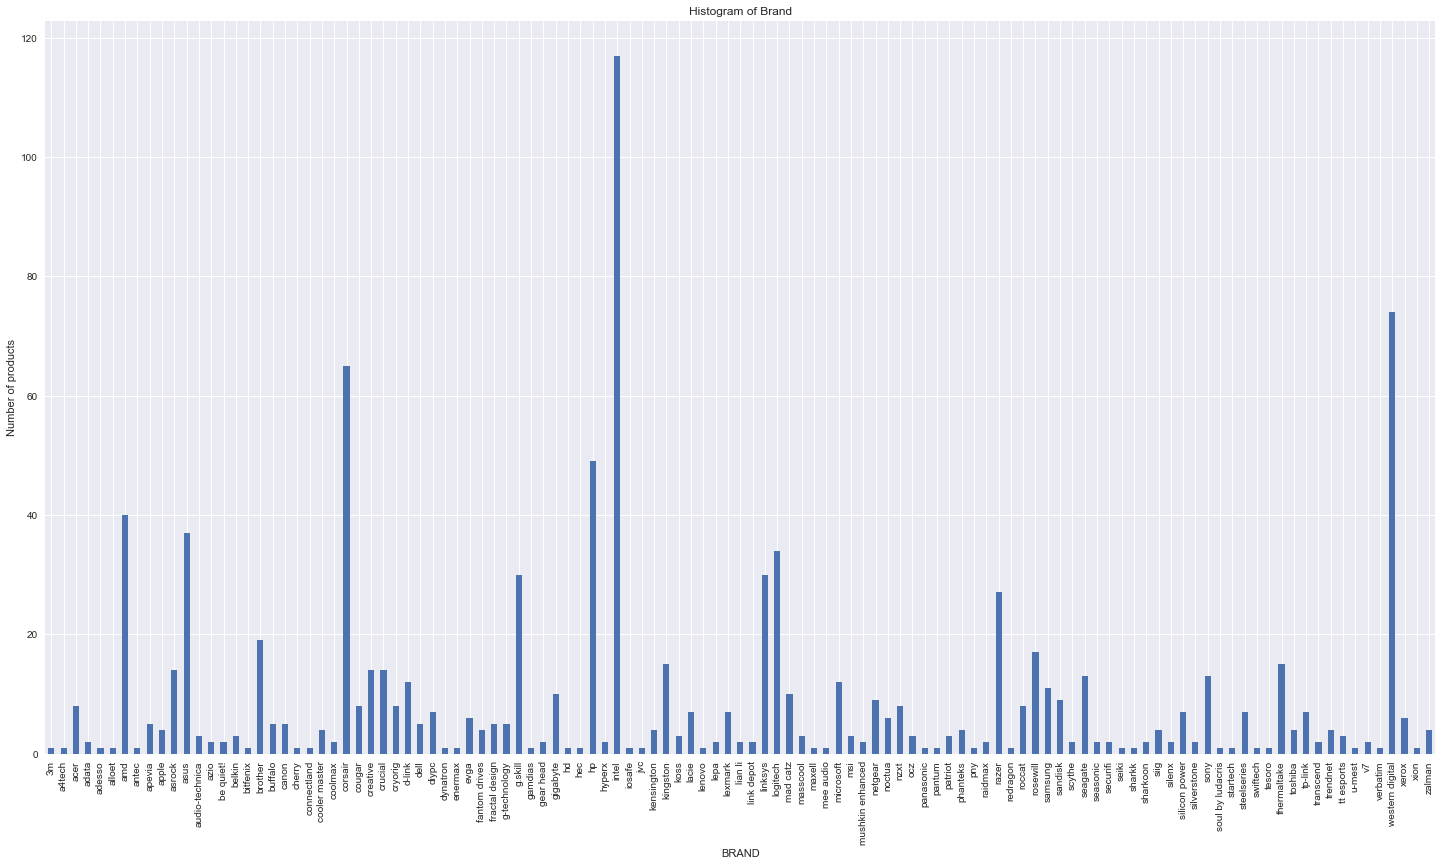

In [12]:
# plt.figure(figsize=(20, 10))
# ax = plt.hist(points['BRAND'])
# plt.title("Histogram of Brand")
# plt.xlabel("BRAND")
# plt.show()
fig = plt.figure(figsize=(20, 12));
df.groupby('BRAND').size().plot(kind='bar');
fig.tight_layout()
plt.ylabel("Number of products")
plt.xlabel("BRAND")
plt.title("Histogram of Brand")
plt.savefig("Brand.jpg");
plt.show();

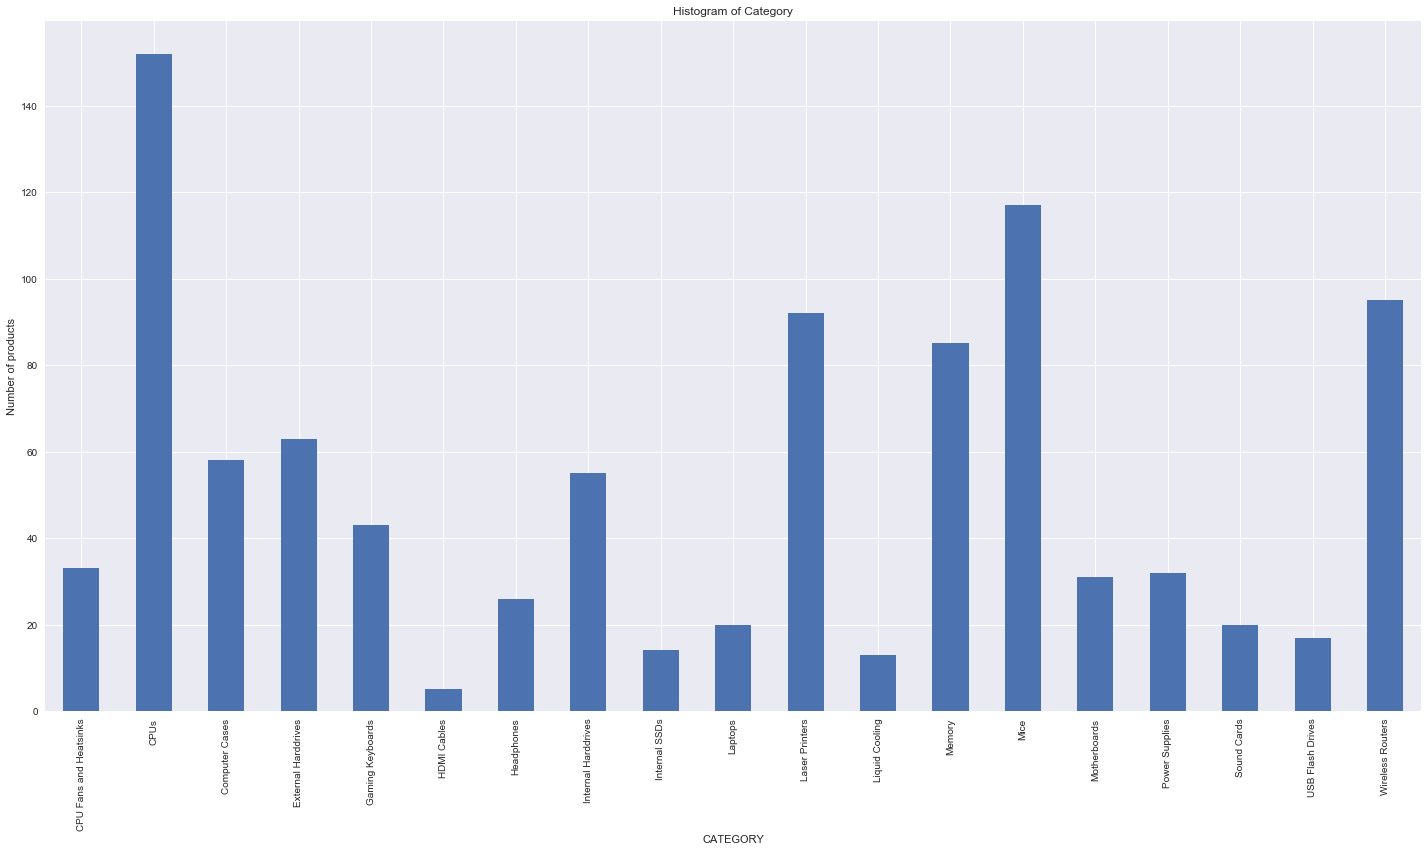

In [13]:
# plt.figure(figsize=(10, 10))
# plt.hist(points['CATEGORY'])
# plt.title("Histogram of Category")
# plt.show()
fig = plt.figure(figsize=(20, 12))
plt.ylabel("Number of products")
plt.xlabel("CATEGORY")
plt.title("Histogram of Category")
df.groupby('CATEGORY').size().plot(kind='bar')
fig.tight_layout()
plt.savefig("Category.jpg");
plt.show()

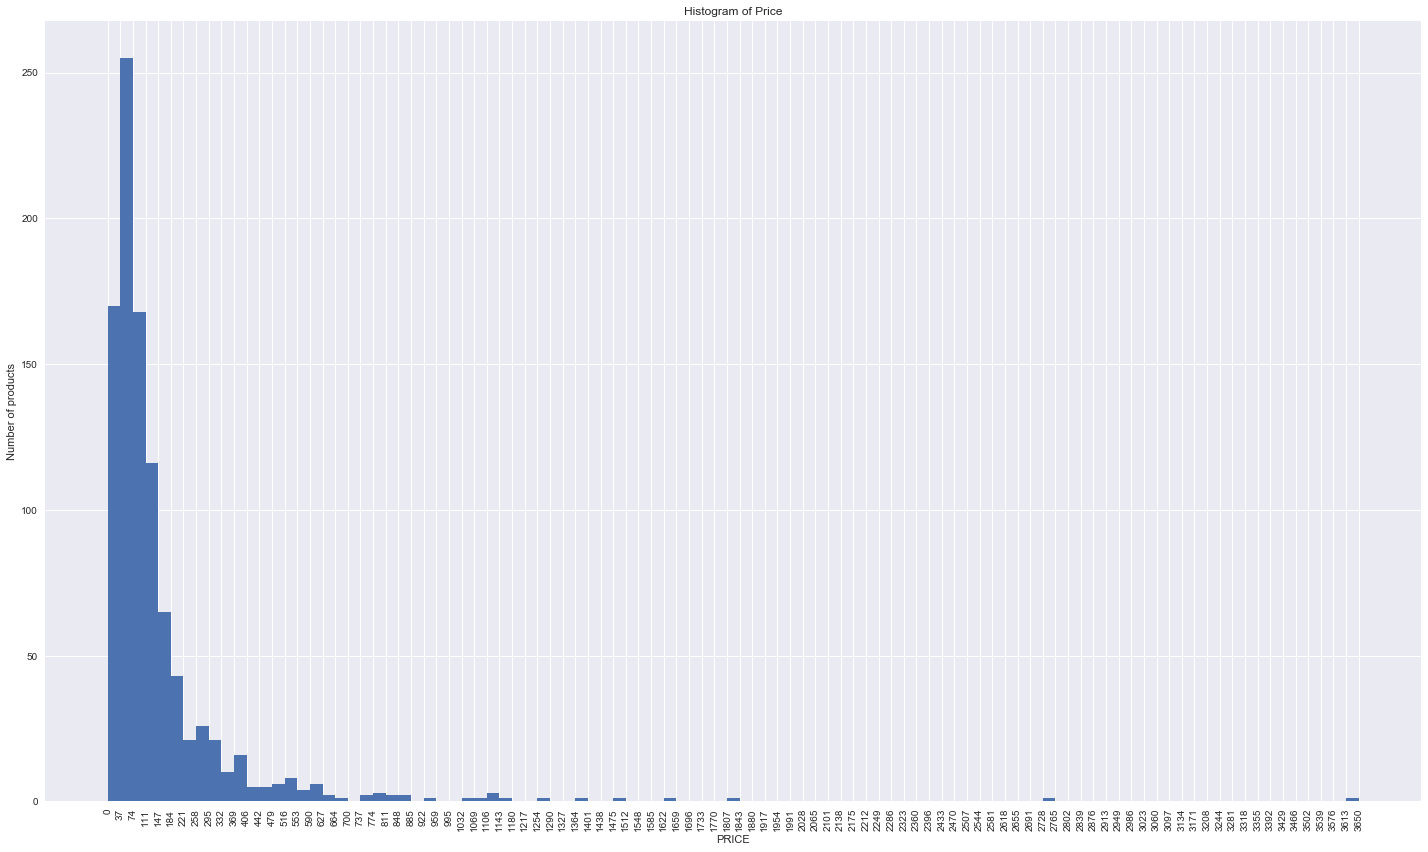

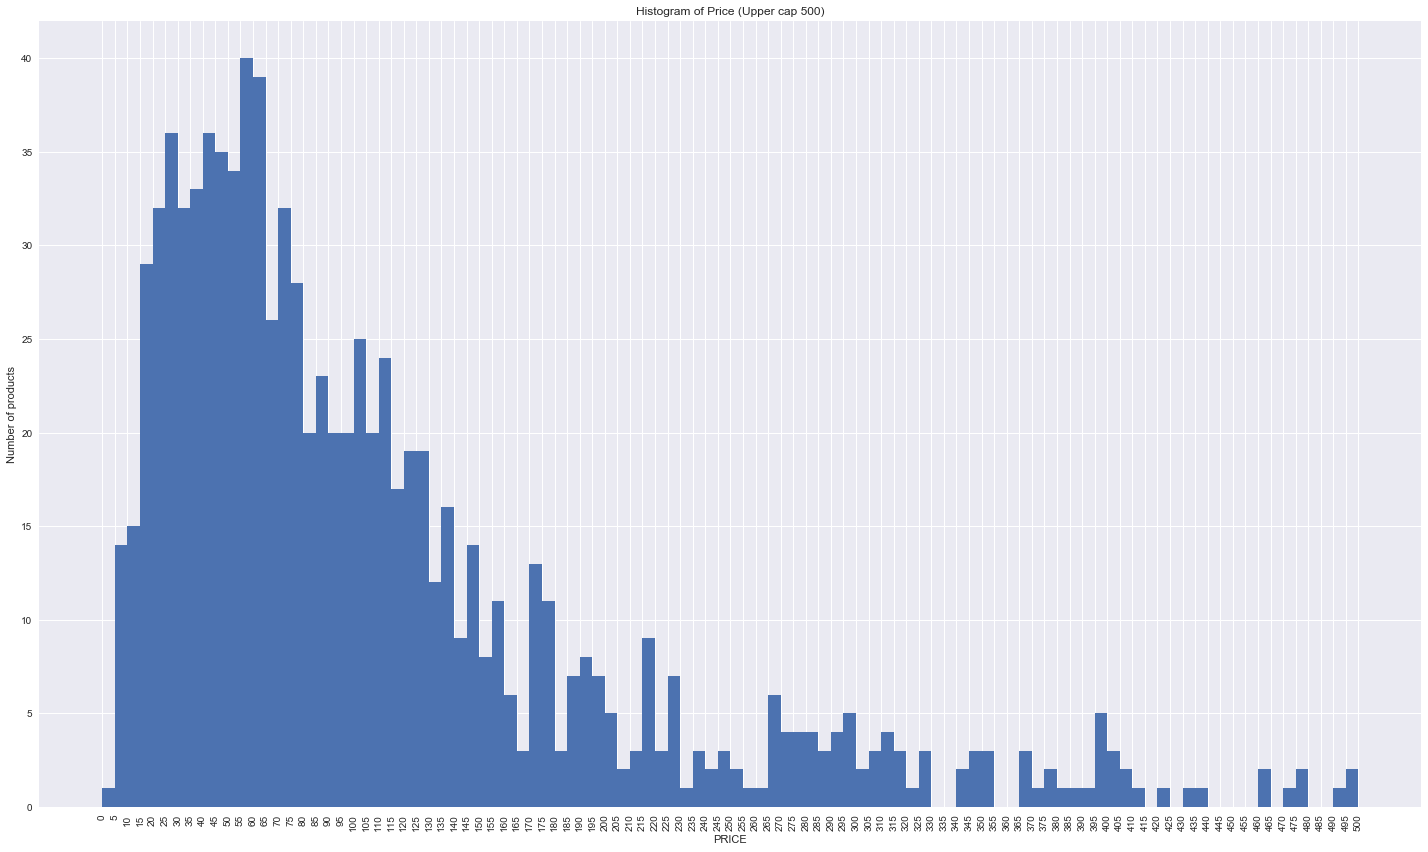

In [114]:
fig = plt.figure(figsize=(20, 12))
bins = np.linspace(0, max(df['PRICE']), 100)
plt.subplot(111)
plt.hist(df['PRICE'], bins)
plt.title("Histogram of Price")
plt.xlabel("PRICE")
plt.ylabel("Number of products")
plt.xticks(bins, rotation=90)
fig.tight_layout()
plt.savefig("Price.jpg");

fig = plt.figure(figsize=(20, 12))
bins = np.linspace(0, 500, 101)
plt.subplot(111)
plt.hist(df['PRICE'], bins)
plt.title("Histogram of Price (Upper cap 500)")
plt.xlabel("PRICE")
plt.ylabel("Number of products")
plt.xticks(bins, rotation=90)
fig.tight_layout()
plt.savefig("Price_refined.jpg");

plt.show()

#### Plot Price ~ Avg Ratings

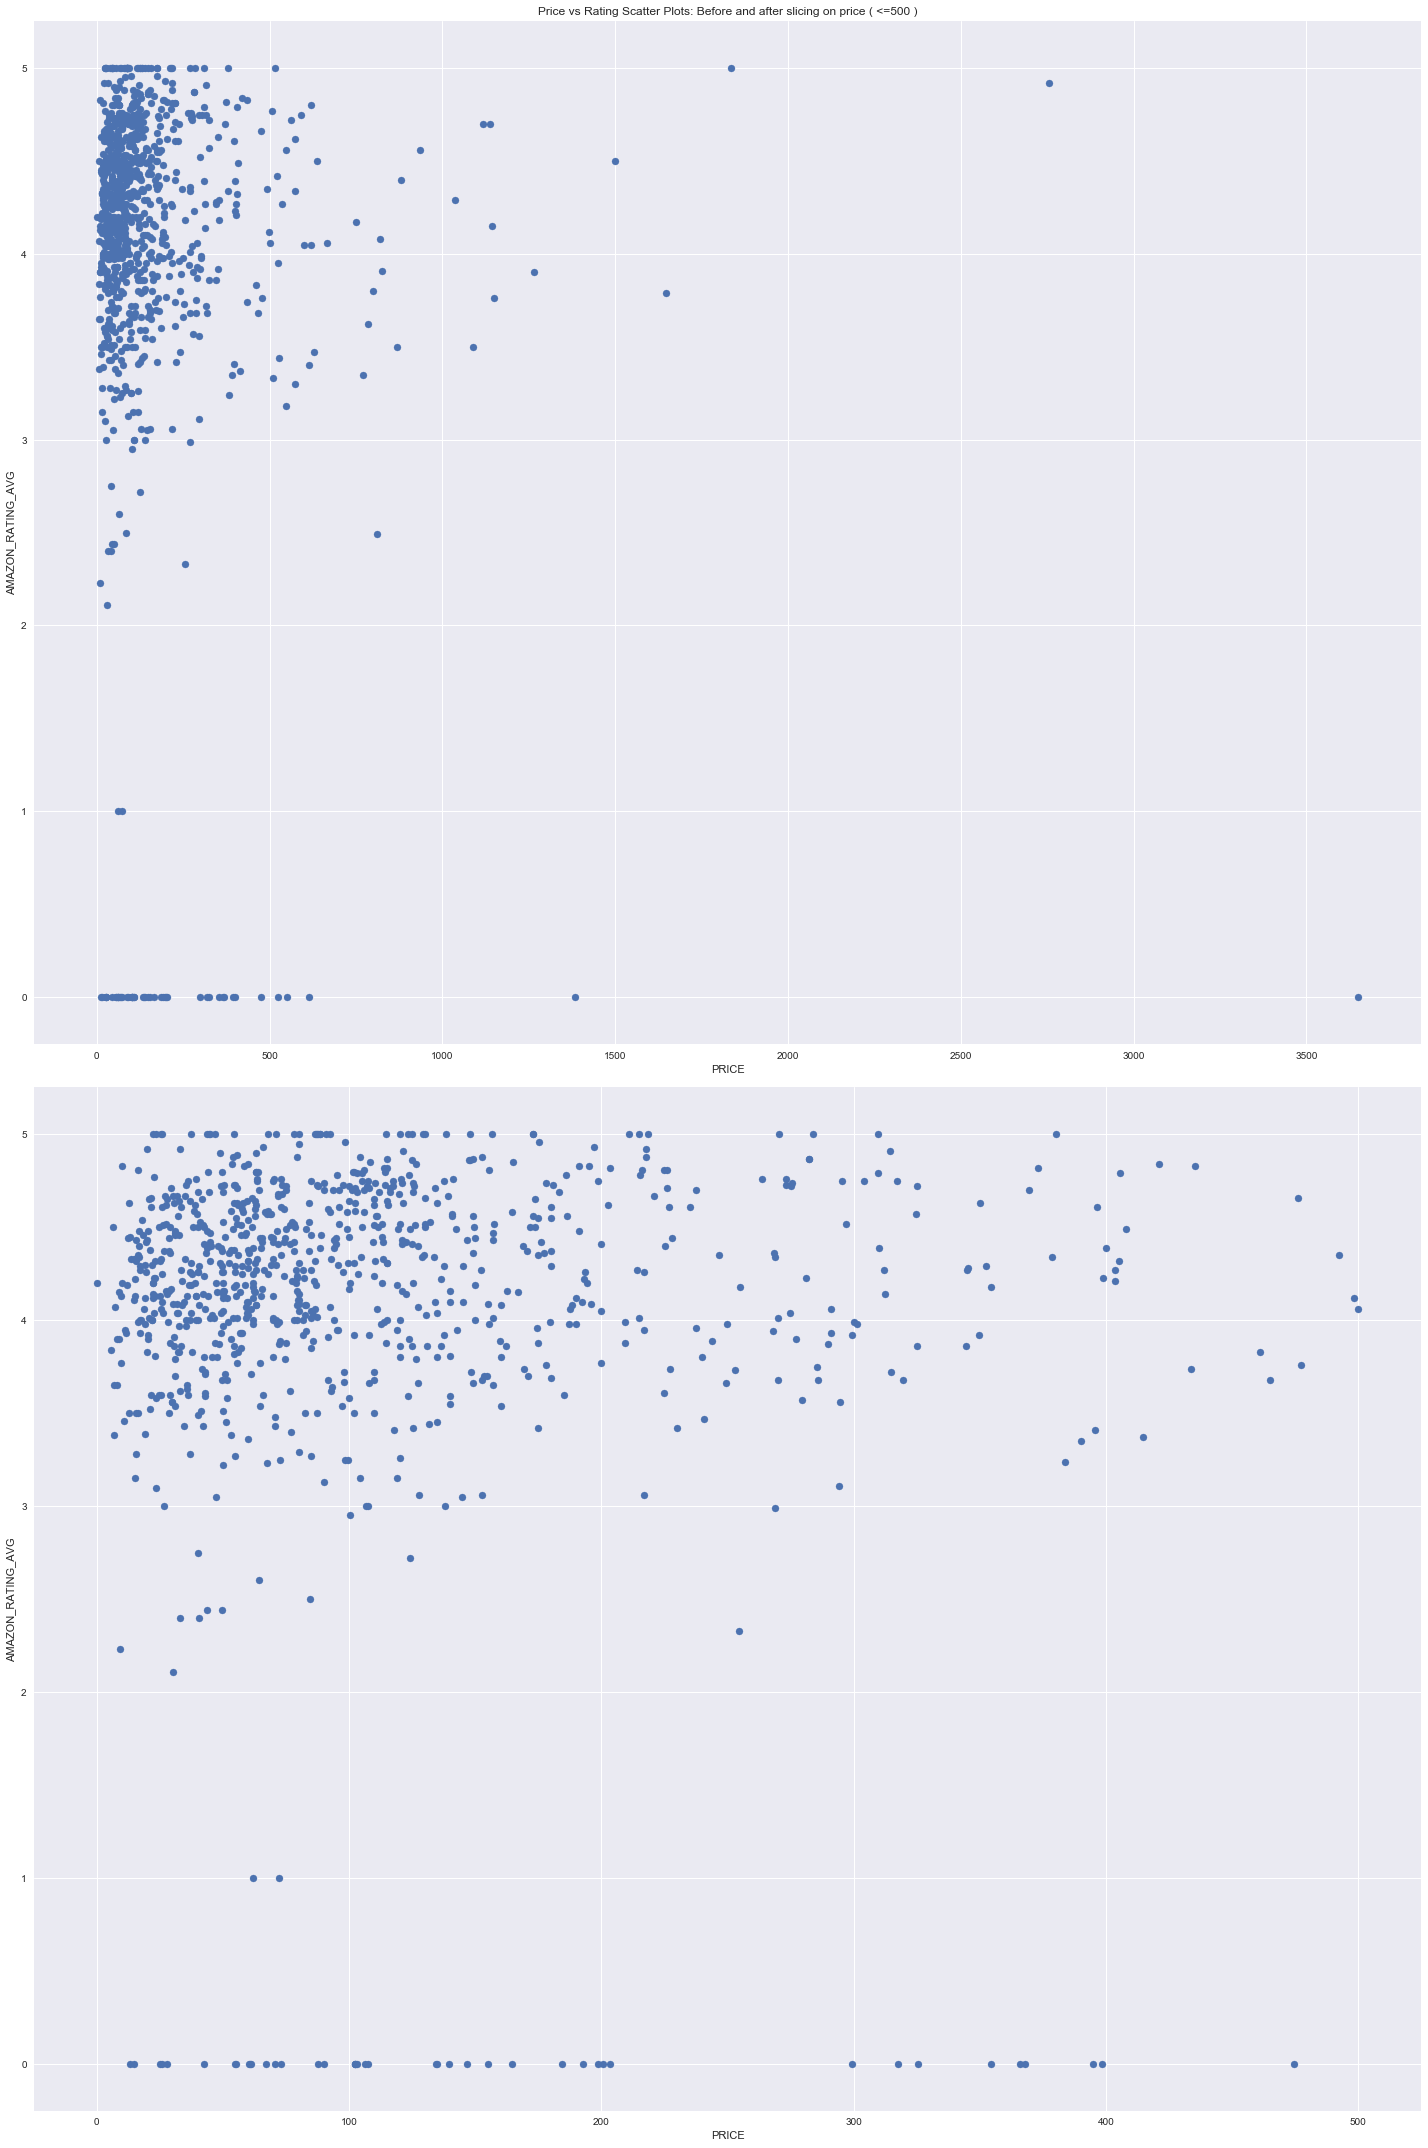

In [113]:
fig = plt.figure(figsize=(20, 30))
yratings = list(points['AMAZON_RATING_AVG'])

ax = plt.subplot(211)
xprices = list(df['PRICE'])
plt.scatter(xprices, yratings)
plt.title("Price vs Rating Scatter Plots: Before and after slicing on price ( <=500 )")
ax.set_xlabel("PRICE")
ax.set_ylabel("AMAZON_RATING_AVG")
fig.tight_layout()

ax = plt.subplot(212)
xNewPrices = list(points['PRICE'])
plt.scatter(xNewPrices, yratings)
# plt.title("After refining")
ax.set_xlabel("PRICE")
ax.set_ylabel("AMAZON_RATING_AVG")
fig.tight_layout()
plt.savefig("Price_Rating.jpg")


plt.show()

#### Plot Category/Brand ~ Avg Ratings

In [16]:
# brand: popularity sort
# category: popularity sort

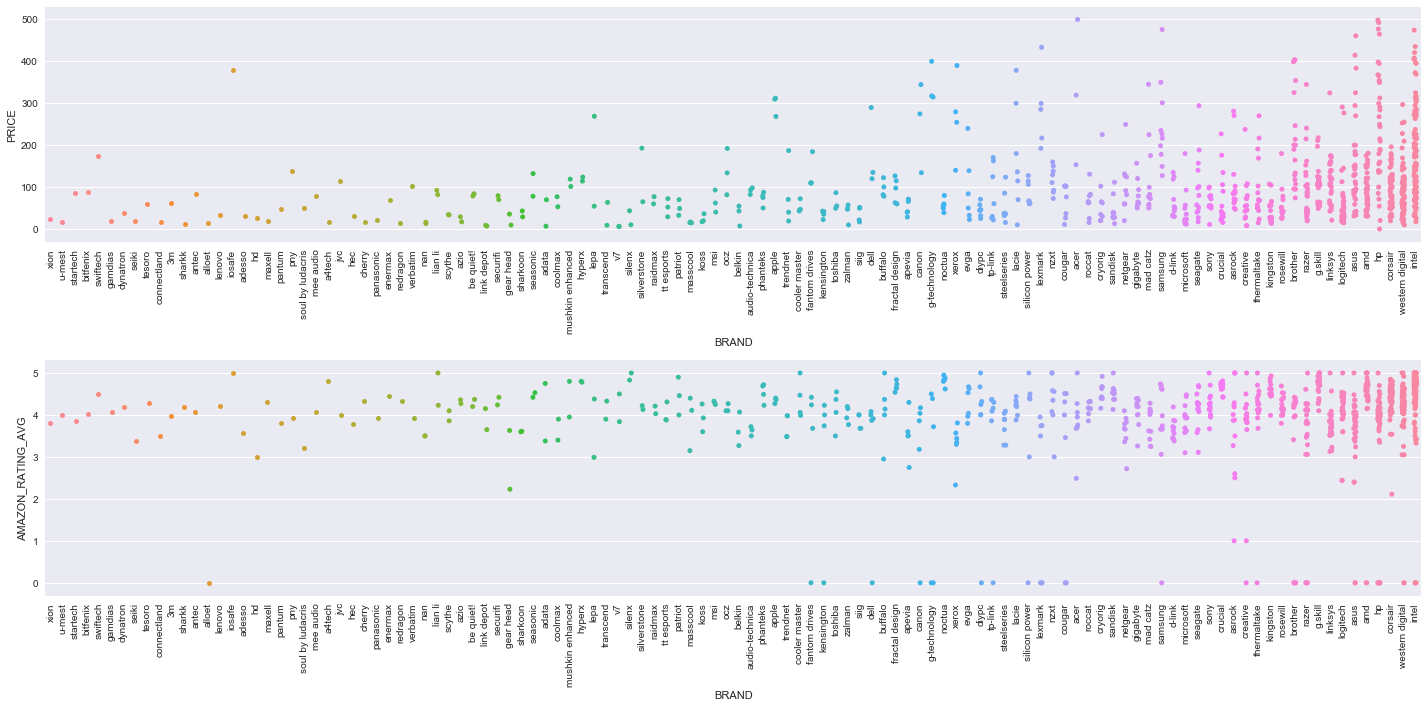

In [108]:
fig = plt.figure(figsize=(20,10))

ax = plt.subplot(211)
sns.stripplot(x='BRAND', y="PRICE", data=points, jitter=True)
ax.set_xticklabels(bList, rotation=90)

fig.tight_layout()
ax = plt.subplot(212)
sns.stripplot(x='BRAND', y="AMAZON_RATING_AVG", data=points, jitter=True)
ax.set_xticklabels(bList, rotation=90)
fig.tight_layout()

plt.savefig("Brand_Price_Rating.jpg")

plt.show()

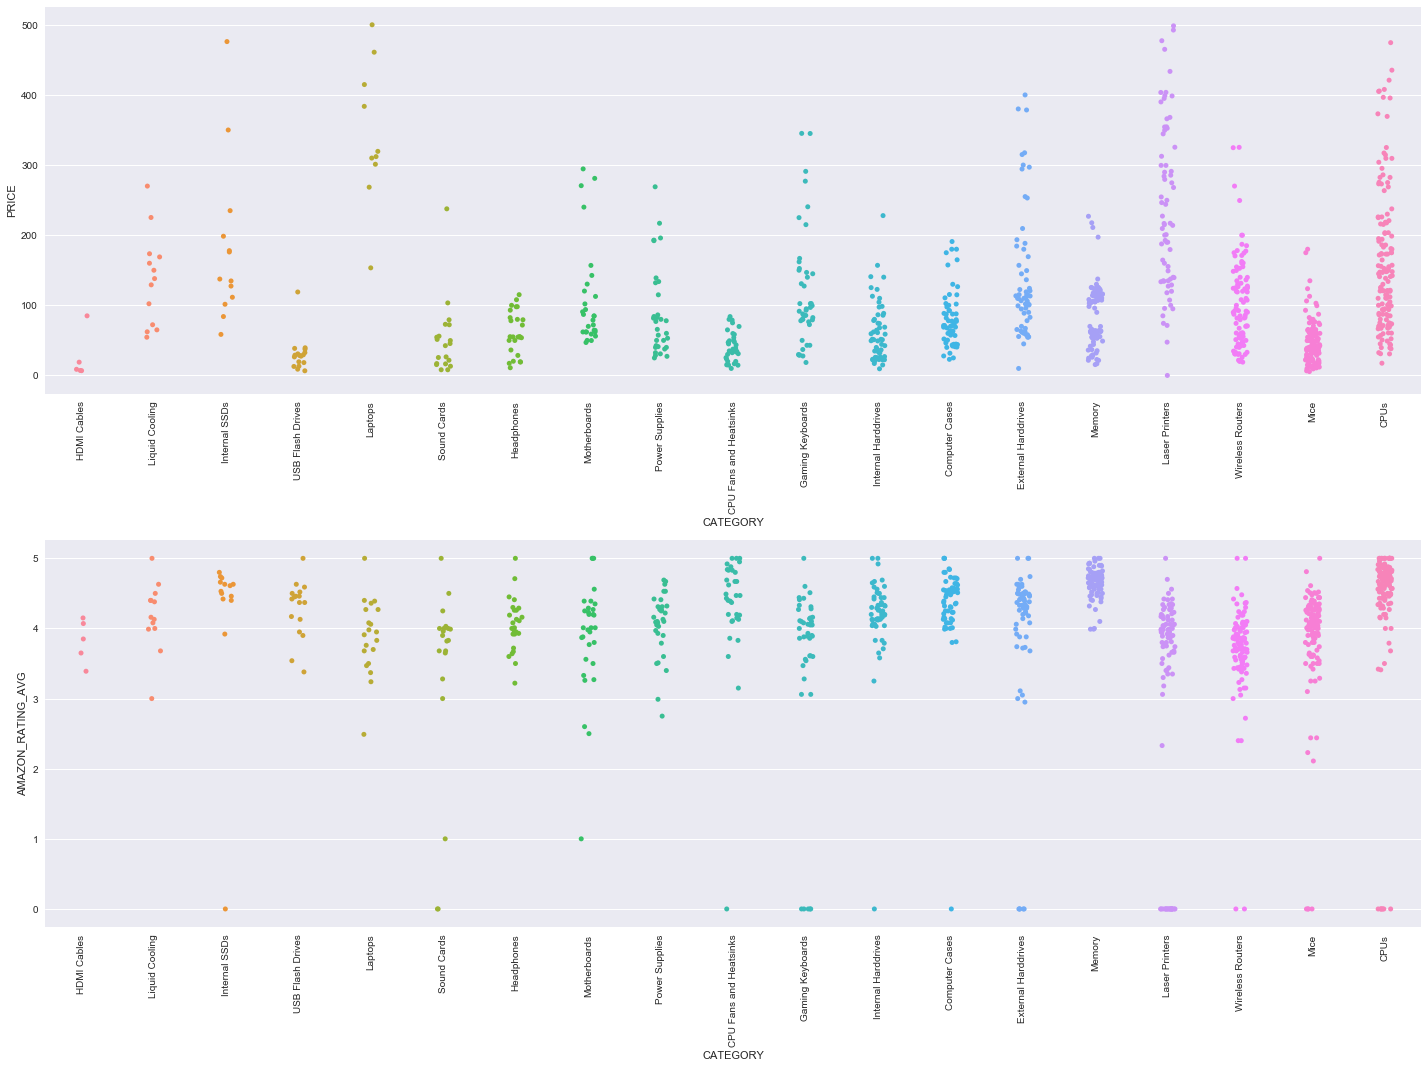

In [107]:
fig = plt.figure(figsize=(20,15))

# cArray = list(reversed(cList))
ax =plt.subplot(211)
plt.subplots_adjust(bottom=-3)
sns.stripplot(x='CATEGORY', y="PRICE", data=points, jitter=True)
ax.set_xticklabels(cList, rotation=90)

ax =plt.subplot(212)
sns.stripplot(x='CATEGORY', y="AMAZON_RATING_AVG", data=points, jitter=True)
ax.set_xticklabels(cList, rotation=90)

fig.tight_layout()
plt.savefig("Category_Price_Rating.jpg")

plt.show()

### Clustering

In [19]:
cols = ["AMAZON_RATING_1", "AMAZON_RATING_2", "AMAZON_RATING_3", 
           "AMAZON_RATING_4", "AMAZON_RATING_5"]
nPoints = len(cols)
X = df[cols]

In [20]:
import pickle
filename = 'kmean_model.sav'
# pickle.dump(estimator, open(filename, "wb" ) )

In [21]:
nClusters = 3 # Dislike - No idea - Like

# estimator = KMeans(n_clusters=nClusters)#, random_state=0)
# estimator.fit(X)
# General Evaluation function
estimator = pickle.load(open(filename, 'rb'))

labels = estimator.labels_

g = [None] * nClusters
for i in range(nClusters):
    g[i] = df[labels == i]

#### Visualize clusters

In [109]:
points['LABEL'] = labels
ys = list(points['CATEGORY'])
# xs = list(cList)
xs = list(points['BRAND'])
# ys = list(bList)
zs = [get_price(p, 4500) for p in points['PRICE']];

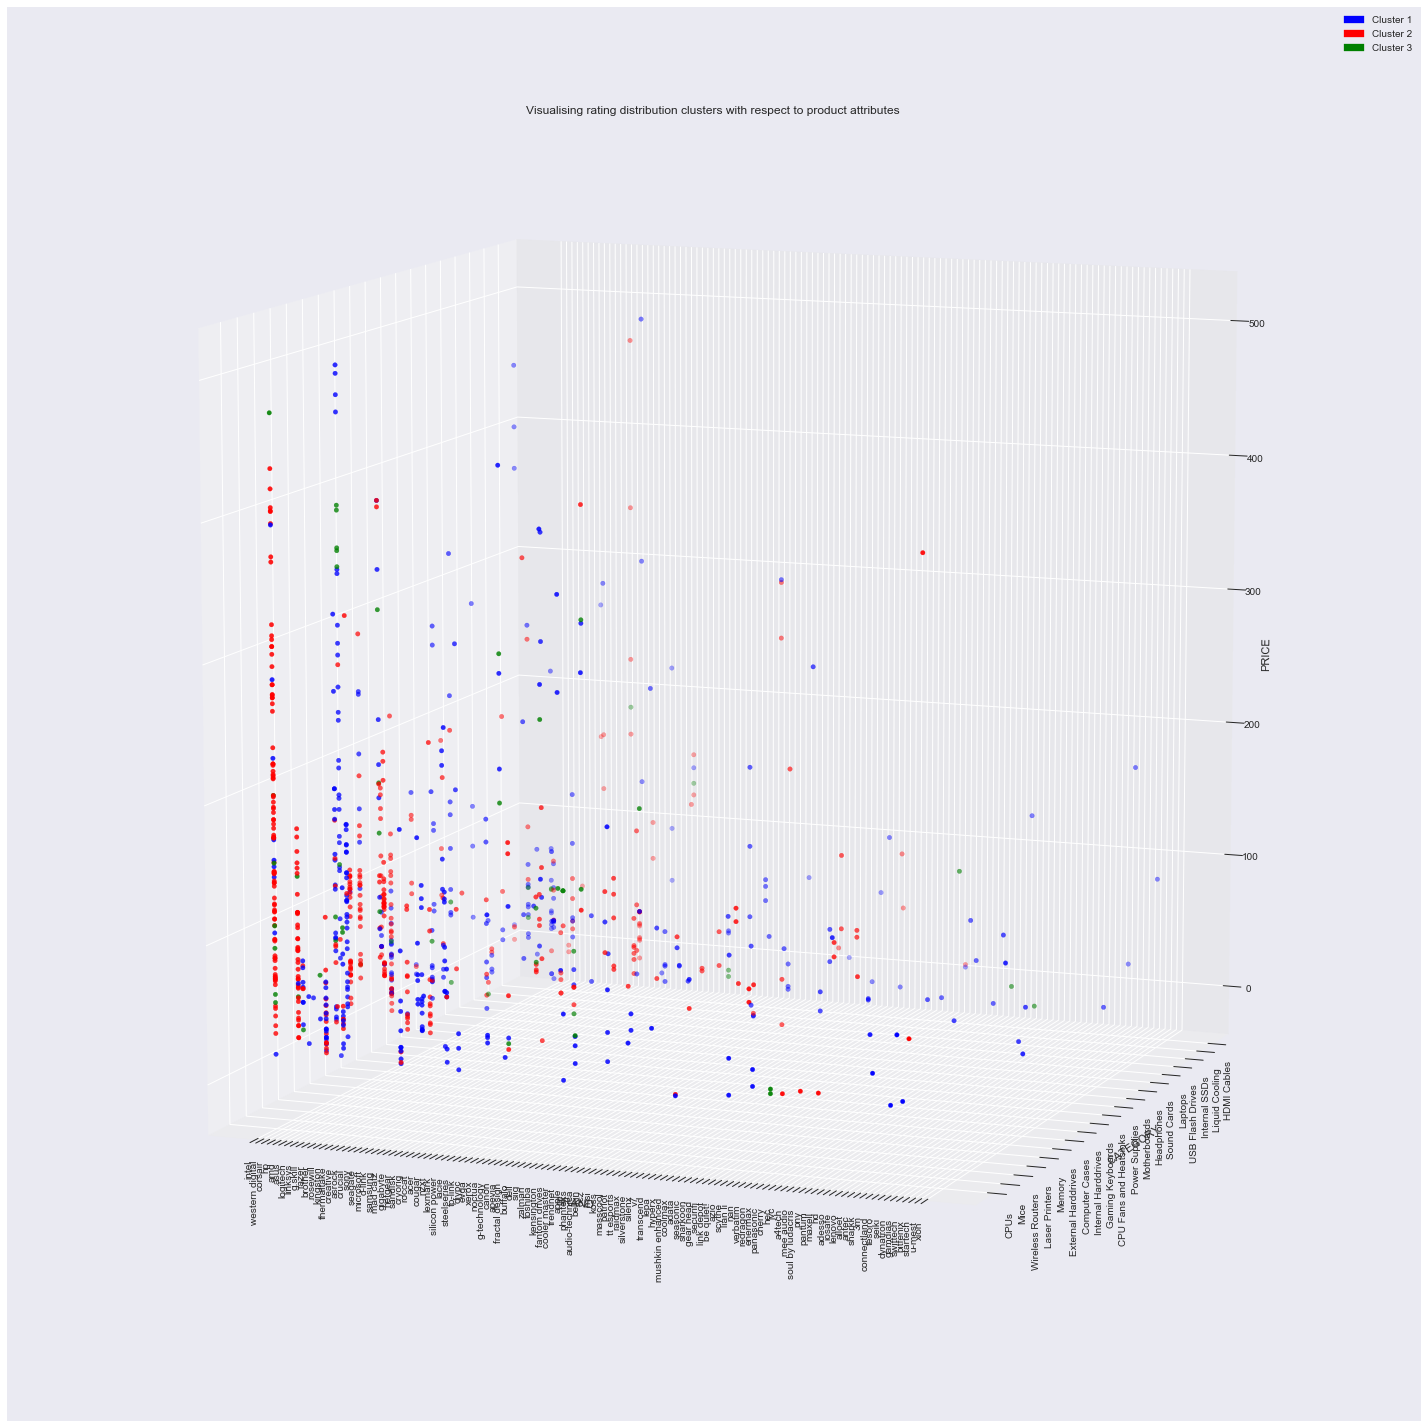

In [110]:
from mpl_toolkits.mplot3d import Axes3D
colors = ['b', 'r', 'g']
colorList =[colors[i] for i in points['LABEL']]

cbins = np.linspace(1, 19, 19)
bbins = np.linspace(1, 114, 114)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=colorList, marker='o')
plt.xticks(bbins)
plt.yticks(cbins)
ax.set_ylabel("CATEGORY")
ax.set_yticklabels(cList, rotation=90)
ax.set_xlabel("BRAND")
ax.set_xticklabels(bList, rotation=90)
ax.set_zlabel("PRICE")
# ax.scatter(xs, zs, c=cList, marker='o')
#ax.legend()
ax.azim = 111
ax.elev = 10
fig.tight_layout()
legend=[]
for i in range(nClusters):
    legend.append(mpatches.Patch(color=colors[i], label='Cluster '+str(i + 1)))
plt.legend(handles=legend)
plt.title("Visualising rating distribution clusters with respect to product attributes ")

plt.savefig("Cluster_Cube.jpg")
plt.show()

### Analyze Clusters

In [24]:
ratingDist = [0] * nClusters
for i in range(nClusters):
    try:
        if sum(g[i]['AMAZON_NUM_REVIEWS']) == 0:
            ratingDist[i] = [0] * 5
        else:
            ratingDist[i] = [np.average(g[i]['AMAZON_RATING_' + str(k)], 
                    weights=g[i]['AMAZON_NUM_REVIEWS']) for k in range(1, 6)]
    except Exception as e:
        print(e)
#         from IPython import embed; embed()

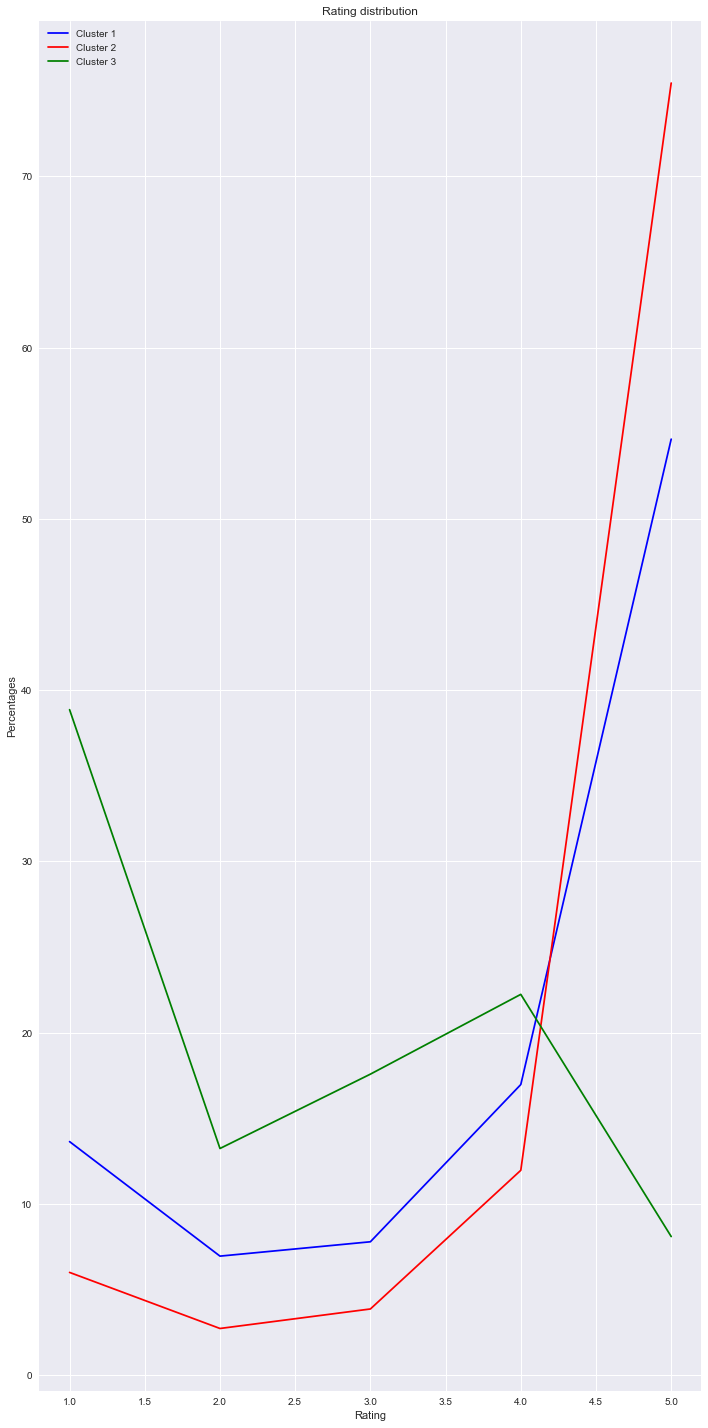

In [125]:
fig = plt.figure(figsize=(10,20))

plt.title("Rating distribution")
for i in range(nClusters):
    plt.plot(range(1, 6), ratingDist[i], label='Cluster '+str(i + 1), color= colors[i])
plt.xlabel('Rating')
plt.ylabel('Percentages')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(loc="upper left")
fig.tight_layout()
plt.savefig("Cluster_Rating.jpg")
plt.show()

#### Some analysis
- 2 is always the least common
- Higher price -> less interested

C:\Anaconda2\envs\py35\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


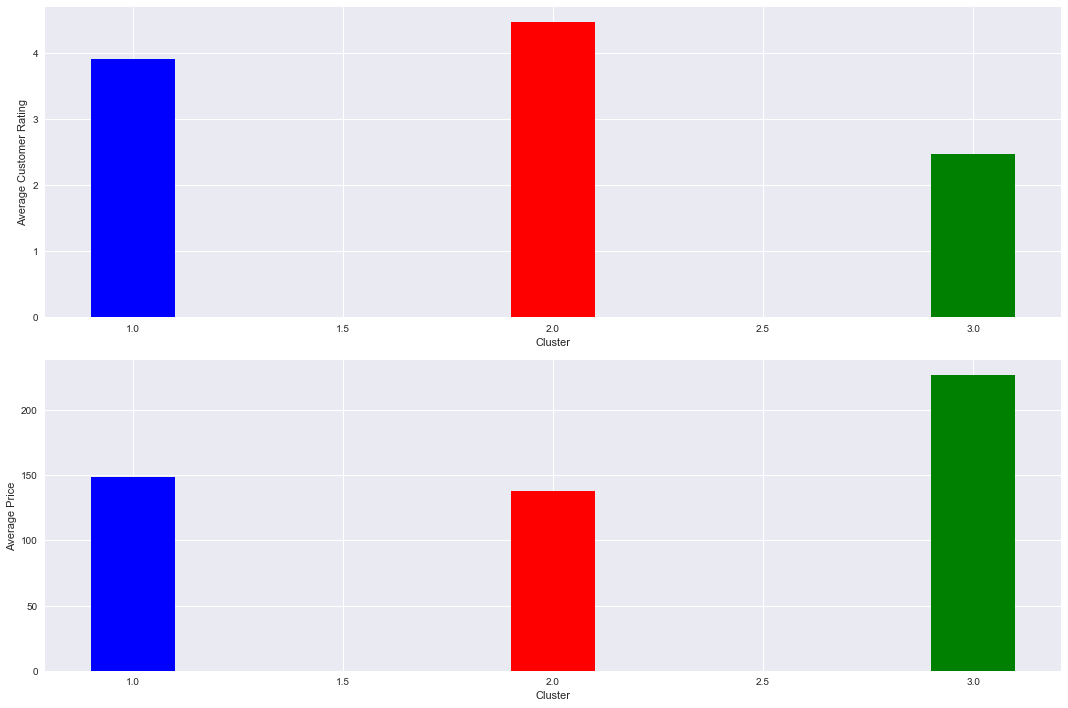

In [129]:
index = np.arange(1,nClusters+1)

labels = ["Cluster 1", "Cluster 2", "Cluster 3"]

yRating = [np.average(g[i]['AMAZON_RATING_AVG'], 
                weights=g[i]['AMAZON_NUM_REVIEWS']) for i in range(nClusters)]
yPrice = [np.mean(g[i]['PRICE']) for i in range(nClusters)] 

fig = plt.figure(figsize=(15,10))
bar_width = 0.2
ax = plt.subplot(211)
plt.bar(index, yRating, width=bar_width, color=colors)
plt.legend()
ax.set_xlabel("Cluster")
ax.set_ylabel("Average Customer Rating")

ax = plt.subplot(212)
plt.bar(index, yPrice, width=bar_width, color=colors)
plt.legend()
ax.set_xlabel("Cluster")
ax.set_ylabel("Average Price")

fig.tight_layout()
plt.savefig('Cluster_Analysis.jpg')
plt.show()